In [1]:
%load_ext autoreload
%autoreload 
import Bayes_fun as bf
import utils as util
import Overlord
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#get default parameters, can add your own before or after!
param = util.get_default_param()


# Load in the data

#The channel position i.e location of active channels is assumed to be the same for all recording sessions
ChannelPos = np.load(r'Data\Mouse1\AL032\2019-11-21\Probe0\1\channel_positions.npy')

#This makes position 3-D by inserting an axis of all one's in the first axis, to allow easy extension to 3-D coords
ChannelPos = np.insert(ChannelPos,0, np.ones(ChannelPos.shape[0]), axis =1)

#path to the average waveforms for each session
WaveF_path1 = r'Data\Mouse1\AL032\2019-11-21\Probe0\1\RawWaveforms'
WaveF_path2 = r'Data\Mouse1\AL032\2019-11-22\Probe0\1\RawWaveforms'
WaveF_path3 = r'Data\Mouse1\AL032\2019-12-03\RawWaveforms'

#path to a tsv file, where the second column contains 'good' for all units you want to include
unit_label_path1 = r'Data\Mouse1\AL032\2019-11-21\Probe0\1\cluster_group.tsv'
unit_label_path2 = r'Data\Mouse1\AL032\2019-11-22\Probe0\1\cluster_group.tsv'
unit_label_path3 = r'Data\Mouse1\AL032\2019-12-03\cluster_group.tsv'

#make paths into a list
WaveF_paths = [WaveF_path1 , WaveF_path2]
unit_label_paths = [unit_label_path1, unit_label_path2]

# Un-comment belowif wanting to use 3 sessions 
# WaveF_paths = [WaveF_path1 , WaveF_path2,WaveF_path3]
# unit_label_paths = [unit_label_path1, unit_label_path2, unit_label_path3]


In [3]:
#Load In waveform
waveform, sessionid, SessionSwitch, WithinSession, param = util.load_good_waveforms(WaveF_paths, unit_label_paths, param)

#Extract parameters from waveform
ExtractedWaveProperties = Overlord.extract_parameters(waveform, ChannelPos, param)

#Extract metric scores
TotalScore, CandidatePairs, Scores2Include, Predictors  = Overlord.extract_metric_scores(ExtractedWaveProperties, SessionSwitch, WithinSession, param, n_iterations  = 2)

#Probability analysis
priorMatch = 1 - (param['nExpectedMatches'] / param['n_units']**2 ) # fredom of choid in prior prob?
Priors = np.array((priorMatch, 1-priorMatch))

labels = CandidatePairs.astype(int)
Cond = np.unique(labels)
ScoreVector = param['ScoreVector']
ParameterKernels = np.full((len(ScoreVector), len(Scores2Include), len(Cond)), np.nan)

ParameterKernels = bf.get_ParameterKernels(Scores2Include, labels, Cond, param, addone = 1)

Probability = bf.apply_naive_bayes(ParameterKernels, Priors, Predictors, param, Cond)

Output = Probability[:,1].reshape(param['n_units'],param['n_units'])

c:\Users\Experiment\Documents\temp\UnitMatch\UMPy\Metrics_fun.py:219: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dimid1,:,:,:,:] - x2[dimid1,:,:,:,:]) / np.abs(x1[dimid2,:,:,:,:] - x2[dimid2,:,:,:,:])


Done drift correction per shank for session pair 1 and 2
Session pair 2 / 3 has [30  9 27 29] matches per shank, which is below threshold to do per shank drift correction


The percentage of units matched to themselves is: 95.7002457002457%
The percentage of false -ve's then is: 4.299754299754298% 

The rate of miss-match(es) per expected match 0.10565110565110565
The percentage of false +ve's is 0.028569202399813004% for session 1
The percentage of false +ve's is 0.03717472118959108% for session 2
The percentage of false +ve's is 0.052489714853170666% for session 3

This assumes that the spike sorter has made no mistakes


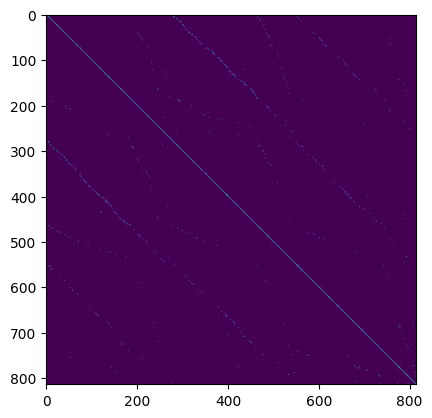

In [4]:
util.evaluate_output(Output, param, WithinSession, SessionSwitch, match_threshold = 0.75)

match_threshold = 0.5
thrs_output = np.zeros_like(Output)
thrs_output[Output > match_threshold] = 1

plt.imshow(thrs_output)
